<a href="https://colab.research.google.com/github/SophyyCC/GEOG761-Project/blob/main/updated_christchurch_soil_moisture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='disco-skyline-467321-e2')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio scikit-image numpy matplotlib
!pip install scipy

In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_origin
from rasterio.io import MemoryFile
from rasterio.windows import from_bounds
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import box, mapping
import xarray as xr
from skimage.morphology import footprint_rectangle
from skimage.filters import rank
from osgeo import gdal, osr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.ndimage import uniform_filter



In [ ]:
hh1_path = "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6300_RT1_HH.tif"

with rasterio.open(hh1_path) as src:
    hh1 = src.read(1)  # read the first band
    hh1_profile = src.profile  # store metadata if needed

print("HH1 shape:", hh1.shape)

HH1 shape: (6276, 6675)


In [ ]:
hh2_path = "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6290_RT1_HH.tif"

with rasterio.open(hh2_path) as src:
    hh2 = src.read(1)  # read the first band
    hh2_profile = src.profile  # store metadata if needed

print("HH2 shape:", hh2.shape)

HH2 shape: (6284, 6732)


In [ ]:
hv1_path = "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6300_RT1_HV.tif"

with rasterio.open(hv1_path) as src:
    hv1 = src.read(1)  # read the first band
    hv1_profile = src.profile  # store metadata if needed

print("HV1 shape:", hv1.shape)

HV1 shape: (6276, 6675)


In [ ]:
hv2_path = "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6290_RT1_HV.tif"

with rasterio.open(hv2_path) as src:
    hv2 = src.read(1)  # read the first band
    hv2_profile = src.profile  # store metadata if needed

print("HV2 shape:", hv2.shape)

HV2 shape: (6284, 6732)


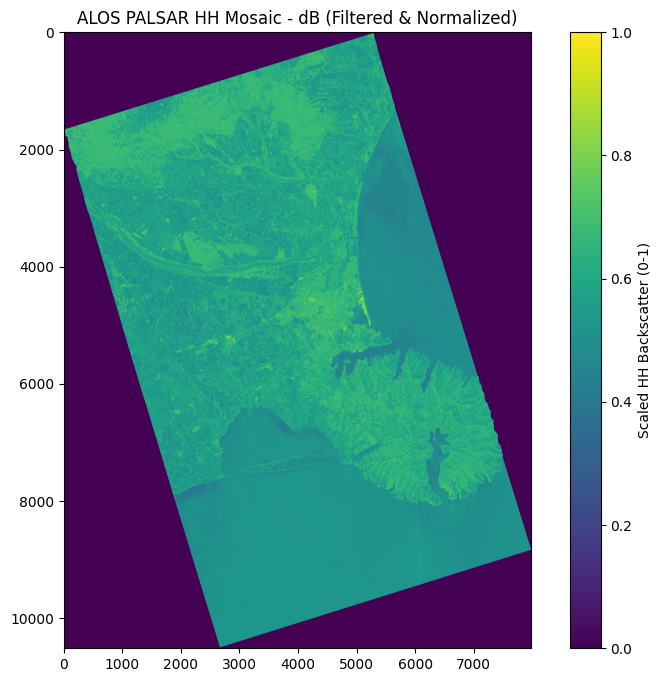

HH filtered mosaic saved as /content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif


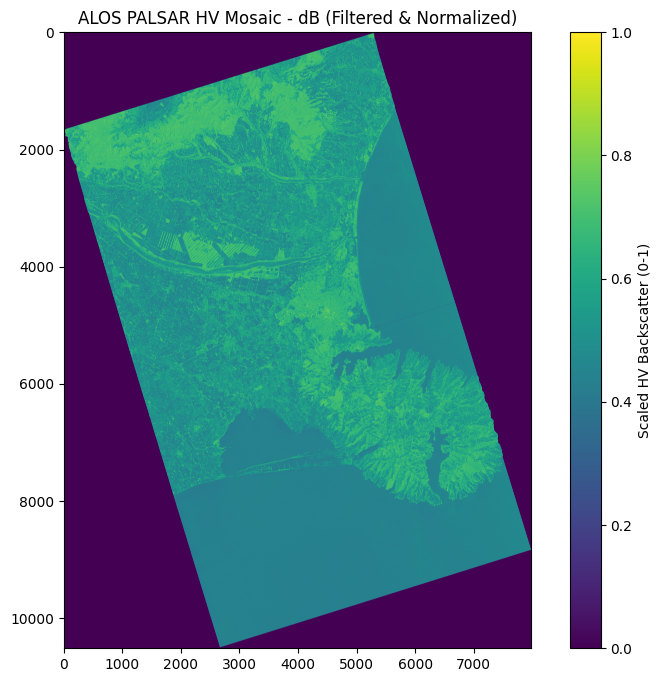

HV filtered mosaic saved as /content/drive/My Drive/Colab Notebooks/HV_mosaic_filtered.tif


In [ ]:
# -----------------------------
# Step 0: Define Refined Lee filter (float version)
# -----------------------------
def refined_lee_float(img, window_size=7):
    """
    Refined Lee speckle filter for SAR imagery (linear backscatter)
    Works on float arrays directly (no 0-255 scaling)

    Parameters:
    - img: 2D NumPy array, linear backscatter (float)
    - window_size: odd integer, size of the moving window

    Returns:
    - filtered: 2D NumPy array, speckle-filtered backscatter
    """
    img = np.where(np.isnan(img), 0, img)

    # Local mean and variance using convolution
    mean_local = uniform_filter(img, size=window_size)
    var_local = uniform_filter((img - mean_local)**2, size=window_size)

    # Estimate noise variance from low-variance areas
    low_var_mask = var_local < np.percentile(var_local, 10)
    var_noise = np.mean(var_local[low_var_mask]) if np.any(low_var_mask) else np.mean(var_local)

    cu = var_noise / (var_local + 1e-12)
    filtered = mean_local + cu * (img - mean_local)
    return filtered

# -----------------------------
# Step 1: Process function for HH or HV
# -----------------------------
def process_sar_tiles(file_list, out_prefix, window_size=7):
    filtered_tiles = []
    profiles = []

    # Step 1a: Filter each tile BEFORE mosaicking
    for f in file_list:
        with rasterio.open(f) as src:
            img = src.read(1).astype(float)
            profile = src.profile
            profiles.append(profile)
            img_filtered = refined_lee_float(img, window_size=window_size)
            filtered_tiles.append(img_filtered)

    # Step 1b: Convert each filtered tile to in-memory dataset
    datasets = []
    for img, prof in zip(filtered_tiles, profiles):
        memfile = MemoryFile()
        with memfile.open(**prof) as dataset:
            dataset.write(img, 1)
        datasets.append(memfile.open())

    # Step 1c: Mosaic the filtered tiles
    mosaic, out_transform = merge(datasets)
    out_meta = profiles[0].copy()
    out_meta.update({
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_transform
    })

    # Step 1d: Convert to dB
    mosaic_linear = mosaic[0]
    mosaic_db = 10 * np.log10(np.clip(mosaic_linear, 1e-6, None))
    mosaic = np.array([mosaic_db])

    # Step 1e: Save clipped mosaic
    minx, miny, maxx, maxy = rasterio.transform.array_bounds(mosaic.shape[1], mosaic.shape[2], out_transform)
    aoi_polygon_proj = box(minx, miny, maxx, maxy)
    aoi_geojson = [mapping(aoi_polygon_proj)]

    # Clip
    with MemoryFile() as memfile:
        with memfile.open(**out_meta) as tmp_ds:
            tmp_ds.write(mosaic)
            clipped, clipped_transform = mask(tmp_ds, aoi_geojson, crop=True)
            clipped_meta = tmp_ds.profile.copy()
            clipped_meta.update({
                "height": clipped.shape[1],
                "width": clipped.shape[2],
                "transform": clipped_transform
            })

    # Save
    out_file = f"/content/drive/My Drive/Colab Notebooks/{out_prefix}_mosaic_filtered.tif"
    with rasterio.open(out_file, "w", **clipped_meta) as dest:
        dest.write(clipped)

    # Plot
    clipped_scaled = (clipped[0] - np.nanmin(clipped[0])) / (np.nanmax(clipped[0]) - np.nanmin(clipped[0]))
    plt.figure(figsize=(10,8))
    plt.imshow(clipped_scaled, cmap='viridis')
    plt.colorbar(label=f'Scaled {out_prefix} Backscatter (0-1)')
    plt.title(f'ALOS PALSAR {out_prefix} Mosaic - dB (Filtered & Normalized)')
    plt.show()

    print(f"{out_prefix} filtered mosaic saved as {out_file}")
    return out_file, clipped, aoi_polygon_proj # Return aoi_polygon_proj

# -----------------------------
# Step 2: HH files
# -----------------------------
hh_files = [
    "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6300_RT1_HH.tif",
    "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6290_RT1_HH.tif"
]

hh_outfile, hh_clipped, aoi_polygon_proj = process_sar_tiles(hh_files, "HH", window_size=7) # Capture aoi_polygon_proj

# -----------------------------
# Step 3: HV files
# -----------------------------
hv_files = [
    "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6300_RT1_HV.tif",
    "/content/drive/My Drive/Colab Notebooks/AP_25343_FBD_F6290_RT1_HV.tif"
]

hv_outfile, hv_clipped, _ = process_sar_tiles(hv_files, "HV", window_size=7) # We don't need aoi_polygon_proj from HV, so use _

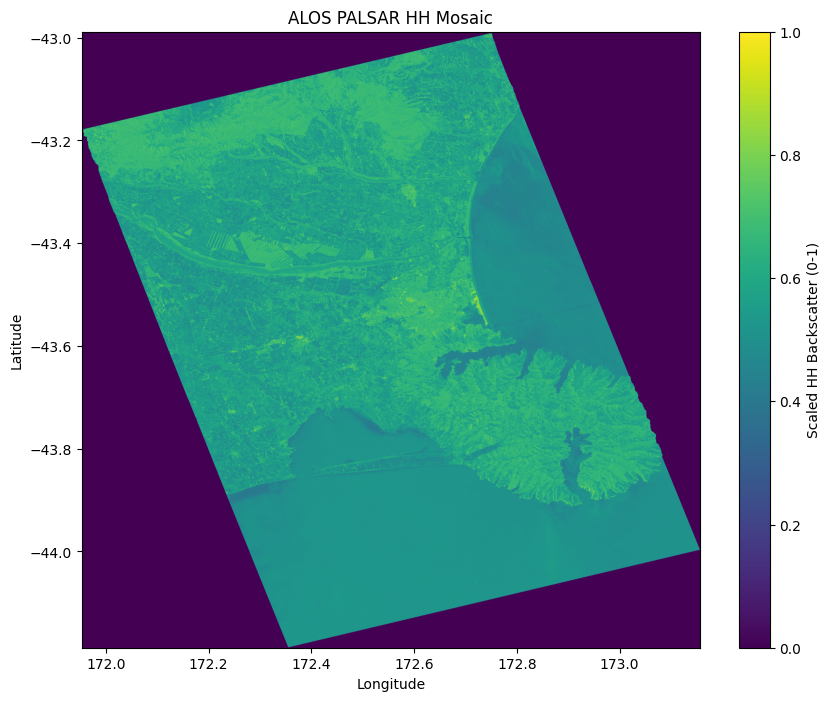

In [ ]:
from pyproj import Transformer
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Plotting in lon/lat instead of array indices
# -----------------------------

# Use the clipped mosaic and its transform
# Access hh_clipped from the previous cell's output
clipped_data = hh_clipped[0]  # single band from hh_clipped
clipped_data_masked = np.ma.masked_invalid(clipped_data)

# Use the transform from the HH processing step
# Assuming hh_profile was stored or accessible - let's get it from the saved tif
hh_filtered_path = "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif"
with rasterio.open(hh_filtered_path) as src:
    clipped_transform = src.transform
    out_meta_crs = src.crs # Use the CRS from the saved file

# Convert raster CRS to lat/lon
transformer = Transformer.from_crs(out_meta_crs, "EPSG:4326", always_xy=True)

height, width = clipped_data.shape
x_coords = np.arange(width) * clipped_transform.a + clipped_transform.c + clipped_transform.a / 2
y_coords = np.arange(height) * clipped_transform.e + clipped_transform.f + clipped_transform.e / 2

lon_min, lat_min = transformer.transform(x_coords[0], y_coords[-1])
lon_max, lat_max = transformer.transform(x_coords[-1], y_coords[0])

# Scale for visualization (0-1)
clipped_scaled = (clipped_data_masked - np.nanmin(clipped_data_masked)) / (
    np.nanmax(clipped_data_masked) - np.nanmin(clipped_data_masked)
)

plt.figure(figsize=(10, 8))
plt.imshow(
    clipped_scaled,
    cmap='viridis',
    extent=[lon_min, lon_max, lat_min, lat_max],
    origin='upper',
    aspect='equal'
)
# Use 'HH' inste ad of the undefined 'out_prefix'
plt.colorbar(label=f'Scaled HH Backscatter (0-1)')
plt.title(f'ALOS PALSAR HH Mosaic')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
# for src in src_files_to_mosaic:
#     print(src.name)
#     print("CRS:", src.crs)
#     print("Bounds:", src.bounds)

In [ ]:
# Step 3: Define path to the ZIP file in your Drive
zip_path = "/content/drive/My Drive/Colab Notebooks/mfe-land-cover-database-v4-0-class-orders-SHP.zip"

# Step 4: Define folder to extract the contents
extract_folder = "/content/landcover"
os.makedirs(extract_folder, exist_ok=True)

# Step 5: Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("ZIP file extracted successfully!")

# Step 6: Check the extracted files
print(os.listdir(extract_folder))

ZIP file extracted successfully!
['land-cover-database-v4-0-class-orders.prj', 'land-cover-database-v4-0-class-orders.pdf', 'land-cover-database-v4-0-class-orders.shx', 'land-cover-database-v4-0-class-orders-ISO.pdf', 'land-cover-database-v4-0-class-orders.dbf', 'land-cover-database-v4-0-class-orders.txt', 'land-cover-database-v4-0-class-orders.shp', 'land-cover-database-v4-0-class-orders.cpg', 'land-cover-database-v4-0-class-orders.xml']


In [ ]:
# Load the landcover vector
# Define the expected folder path where the zip was extracted
extract_folder = "/content/landcover" # Make sure this matches the extraction folder in hPiHIvvLkxk_

lc_file = os.path.join(extract_folder, "land-cover-database-v4-0-class-orders.shp")
lc = gpd.read_file(lc_file)

# Check available fields
print(lc.columns)


# Keep only 2008 columns
lc_2008 = lc[['LCDB_UID', 'Class_2008', 'Name_2008', 'geometry']].copy()

# Optional: rename columns for clarity
lc_2008 = lc_2008.rename(columns={'Class_2008': 'LC_Class', 'Name_2008': 'LC_Name'})
print(lc_2008.crs)

Index(['WET_CONTEX', 'Onshore', 'LCDB_UID', 'EditDate', 'EditAuthor',
       'Class_1996', 'Class_2001', 'Class_2008', 'Class_2012', 'Name_1996',
       'Name_2001', 'Name_2008', 'Name_2012', 'LCDBtoLand', 'LCDBtoLa_1',
       'Land_cover', 'Shape_Leng', 'geometry'],
      dtype='object')
EPSG:2193


In [ ]:
target_crs = "EPSG:32759"
lc_2008_proj = lc_2008.to_crs(target_crs)
print("Landcover reprojected CRS:", lc_2008_proj.crs)

# -----------------------------
# Step 8: Clip Landcover to HH mosaic AOI
# -----------------------------
# Convert AOI polygon to GeoDataFrame
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_polygon_proj], crs="EPSG:32759")
aoi_polygon_proj = aoi_gdf.geometry.iloc[0]

# Clip landcover
lc_2008_clipped = gpd.clip(lc_2008_proj, aoi_gdf)
print("Landcover clipped. Number of features:", len(lc_2008_clipped))

# Optional: check bounds
print("Clipped Landcover bounds:", lc_2008_clipped.total_bounds)

Landcover reprojected CRS: EPSG:32759
Landcover clipped. Number of features: 14911
Clipped Landcover bounds: [ 576137.25       5128629.5604335   671561.14921369 5235187.59899228]


In [ ]:
# paths
ref_raster = "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif"
# Make sure to run the cell that defines lc_2008_clipped before running this cell
lc_gdf = lc_2008_clipped              # your clipped GeoDataFrame
out_lc_raster = "/content/drive/My Drive/Colab Notebooks/landcover_raster.tif"

# 1) Make a mapping of class value -> integer code
# Use the column you want (here 'LC_Class'); adapt if different.
classes = np.sort(lc_gdf['LC_Class'].unique())
# create an explicit mapping dict: original class -> code 1..N
class_to_code = {int(c): i+1 for i, c in enumerate(classes)}  # leave 0 for nodata
print("Landcover classes -> codes:", class_to_code)

# add a column with the integer code (ensures type is int)
lc_gdf['lc_code'] = lc_gdf['LC_Class'].map(class_to_code).astype(np.int32)

# 2) Open reference raster to get transform, crs, shape
with rasterio.open(ref_raster) as ref:
    ref_meta = ref.meta.copy()
    out_transform = ref.transform
    out_crs = ref.crs
    out_height = ref.height
    out_width = ref.width
    out_dtype = rasterio.uint16 if len(classes) > 255 else rasterio.uint8

# 3) Prepare (geometry, value) pairs for rasterize
shapes = ((geom, value) for geom, value in zip(lc_gdf.geometry, lc_gdf['lc_code']))

# 4) Rasterize to match the reference grid exactly
lc_raster_arr = rasterize(
    shapes=shapes,
    out_shape=(out_height, out_width),
    fill=0,                     # background (no-data) value
    transform=out_transform,
    dtype=out_dtype,
    all_touched=True            # <-- assign any pixel touched by geometry
)

# 5) Save raster
out_meta = ref_meta.copy()
out_meta.update({
    'count': 1,
    'dtype': lc_raster_arr.dtype,
    'compress': 'lzw'
})

with rasterio.open(out_lc_raster, 'w', **out_meta) as dst:
    dst.write(lc_raster_arr, 1)

print("Saved landcover raster:", out_lc_raster)

Landcover classes -> codes: {1: 1, 2: 2, 5: 3, 6: 4, 10: 5, 12: 6, 16: 7, 20: 8, 21: 9, 22: 10, 30: 11, 33: 12, 40: 13, 41: 14, 43: 15, 44: 16, 45: 17, 46: 18, 47: 19, 50: 20, 51: 21, 52: 22, 54: 23, 55: 24, 56: 25, 58: 26, 64: 27, 68: 28, 69: 29, 71: 30}
Saved landcover raster: /content/drive/My Drive/Colab Notebooks/landcover_raster.tif


In [ ]:
dem_path = "/content/drive/My Drive/Colab Notebooks/SRTM_DEM.tif"

with rasterio.open(dem_path) as src:
    dem = src.read(1)  # read the first band
    dem_profile = src.profile  # store metadata if needed

print("DEM shape:", dem.shape)
print("DEM CRS:", dem_profile['crs'])

DEM shape: (3515, 6191)
DEM CRS: EPSG:4326


In [ ]:
# -----------------------------
# Paths
# -----------------------------
dem_path = "/content/drive/My Drive/Colab Notebooks/SRTM_DEM.tif"
dem_reproj_path = "/content/drive/My Drive/Colab Notebooks/SRTM_DEM_32759.tif"
dem_clipped_path = "/content/drive/My Drive/Colab Notebooks/DEM_clipped.tif"

# Target CRS same as HH mosaic
target_crs = "EPSG:32759"

# -----------------------------
# Step 1: Reproject DEM to EPSG:32759
# -----------------------------

with rasterio.open(dem_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    dem_reproj = np.empty((height, width), dtype=src.dtypes[0])
    reproject(
        source=rasterio.band(src, 1),
        destination=dem_reproj,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=target_crs,
        resampling=Resampling.bilinear
    )

# Save reprojected DEM
with rasterio.open(dem_reproj_path, "w", **kwargs) as dst:
    dst.write(dem_reproj, 1)

print("DEM reprojected to EPSG:32759.")

# -----------------------------
# Step 2: Clip DEM to AOI
# -----------------------------
aoi_geojson = [mapping(aoi_polygon_proj)]  # AOI already in EPSG:32759

with rasterio.open(dem_reproj_path) as src:
    dem_clipped, dem_transform = mask(src, shapes=aoi_geojson, crop=True)
    dem_clipped = dem_clipped[0]  # single band
    dem_meta = src.meta.copy()
    dem_meta.update({
        "height": dem_clipped.shape[0],
        "width": dem_clipped.shape[1],
        "transform": dem_transform,
        "count": 1,
        "dtype": dem_clipped.dtype
    })

with rasterio.open(dem_clipped_path, "w", **dem_meta) as dst:
    dst.write(dem_clipped, 1)

print("DEM clipped to AOI:", dem_clipped_path)

DEM reprojected to EPSG:32759.
DEM clipped to AOI: /content/drive/My Drive/Colab Notebooks/DEM_clipped.tif


In [ ]:

# Full path to the HDF
modis_hdf = "/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf"

# Open HDF
dataset = gdal.Open(modis_hdf, gdal.GA_ReadOnly)
if dataset is None:
    print("Could not open HDF file.")
else:
    print("HDF file opened successfully!")
    subdatasets = dataset.GetSubDatasets()
    print("Available subdatasets:")
    for sd in subdatasets:
        print(sd[0])

/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


HDF file opened successfully!
Available subdatasets:
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days NDVI"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days EVI"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days VI Quality"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days red reflectance"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days NIR reflectance"
HDF4_EOS:EOS_GRID:"/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf":MODIS_Grid_16DAY_250m_500m_VI:"250

In [ ]:

# Full path to the HDF (Google Drive)
modis_hdf = "/content/drive/My Drive/Colab Notebooks/MOD13Q1.A2010289.h30v13.061.2021176120403.hdf"

# Open NDVI subdataset directly
ndvi_path = f'HDF4_EOS:EOS_GRID:"{modis_hdf}":MODIS_Grid_16DAY_250m_500m_VI:"250m 16 days NDVI"'
ndvi_dataset = gdal.Open(ndvi_path, gdal.GA_ReadOnly)

if ndvi_dataset is None:
    print(f"Could not open NDVI subdataset: {ndvi_path}")
else:
    ndvi = ndvi_dataset.ReadAsArray().astype(np.float32)
    ndvi = ndvi * 0.0001  # Apply MODIS scale factor
    print("NDVI data read successfully. Shape:", ndvi.shape)

    # Close the dataset
    ndvi_dataset = None


NDVI data read successfully. Shape: (4800, 4800)


In [ ]:
# Assume 'ndvi' is your NumPy array from the HDF
ndvi_tiff = "/content/drive/My Drive/Colab Notebooks/modis_ndvi.tif"

# Get georeference info from the HDF subdataset
ndvi_dataset = gdal.Open(ndvi_path)
gt = ndvi_dataset.GetGeoTransform()
proj = ndvi_dataset.GetProjection()
ndvi_dataset = None  # Close the dataset

# Save NDVI array as GeoTIFF
driver = gdal.GetDriverByName("GTiff")
rows, cols = ndvi.shape
out_ds = driver.Create(ndvi_tiff, cols, rows, 1, gdal.GDT_Float32)
out_ds.SetGeoTransform(gt)
out_ds.SetProjection(proj)
out_ds.GetRasterBand(1).WriteArray(ndvi)
out_ds.FlushCache()
out_ds = None

print("NDVI saved as GeoTIFF:", ndvi_tiff)

NDVI saved as GeoTIFF: /content/drive/My Drive/Colab Notebooks/modis_ndvi.tif


In [ ]:
# -----------------------------
# Step 1: Open MODIS NDVI GeoTIFF
# -----------------------------
ndvi_tiff = "/content/drive/My Drive/Colab Notebooks/modis_ndvi.tif"
with rasterio.open(ndvi_tiff) as src:
    ndvi_data = src.read(1)
    ndvi_meta = src.meta.copy()
    print("Original NDVI CRS:", src.crs)
    print("Original NDVI bounds:", src.bounds)

# -----------------------------
# Step 2: Reproject NDVI to EPSG:32759
# -----------------------------
target_crs = "EPSG:32759"

with rasterio.open(ndvi_tiff) as src:
    src_crs = src.crs
    src_bounds = src.bounds
    src_width = src.width
    src_height = src.height

transform, width, height = calculate_default_transform(
    src_crs, target_crs, src_width, src_height, *src_bounds
)

ndvi_reproj = np.empty((height, width), dtype=np.float32)

with rasterio.open(ndvi_tiff) as src:
    reproject(
        source=rasterio.band(src, 1),
        destination=ndvi_reproj,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=target_crs,
        resampling=Resampling.bilinear
    )

ndvi_meta.update({
    "crs": target_crs,
    "transform": transform,
    "height": height,
    "width": width,
    "count": 1,
    "dtype": ndvi_reproj.dtype
})


# -----------------------------
# Step 3: Clip NDVI to HH mosaic AOI
# -----------------------------
# AOI polygon (already in EPSG:32759)
aoi_geojson = [mapping(aoi_polygon_proj)]

# Create an in-memory raster with the reprojected NDVI
with rasterio.io.MemoryFile() as memfile:
    with memfile.open(**ndvi_meta) as dataset:
        dataset.write(ndvi_reproj, 1)

        # Clip to AOI
        ndvi_clipped, ndvi_transform = mask(
            dataset,
            shapes=aoi_geojson,
            crop=True
        )

# Update metadata for saving
ndvi_meta.update({
    "height": ndvi_clipped.shape[1],
    "width": ndvi_clipped.shape[2],
    "transform": ndvi_transform
})

# -----------------------------
# Step 4: Save clipped NDVI
# -----------------------------
ndvi_clipped_path = "/content/drive/My Drive/Colab Notebooks/modis_ndvi_clipped.tif"
with rasterio.open(ndvi_clipped_path, "w", **ndvi_meta) as dst:
    dst.write(ndvi_clipped)

print("NDVI reprojected and clipped to AOI:", ndvi_clipped_path)

Original NDVI CRS: PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Original NDVI bounds: BoundingBox(left=13343406.236, bottom=-5559752.598333, right=14455356.755667, top=-4447802.078667)
NDVI reprojected and clipped to AOI: /content/drive/My Drive/Colab Notebooks/modis_ndvi_clipped.tif


In [ ]:
sm_path = "/content/drive/My Drive/Colab Notebooks/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20101027000000-fv09.1.nc"

ds = xr.open_dataset(sm_path)
print(ds)

<xarray.Dataset> Size: 29MB
Dimensions:         (time: 1, lat: 720, lon: 1440)
Coordinates:
  * time            (time) datetime64[ns] 8B 2010-10-27
  * lat             (lat) float32 3kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    sm              (time, lat, lon) float32 4MB ...
    sm_uncertainty  (time, lat, lon) float32 4MB ...
    flag            (time, lat, lon) float32 4MB ...
    freqbandID      (time, lat, lon) int16 2MB ...
    dnflag          (time, lat, lon) int8 1MB ...
    mode            (time, lat, lon) int8 1MB ...
    sensor          (time, lat, lon) int32 4MB ...
    t0              (time, lat, lon) datetime64[ns] 8MB ...
Attributes: (12/44)
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    institution:                  TU Wien (AUT); VanderSat B.V. (NL); Planet ...
    contact:                      cci_sm_contact@eodc.eu
    source:   

In [ ]:
hh_mosaic_path = "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif"
hv_mosaic_path = "/content/drive/My Drive/Colab Notebooks/HV_mosaic_filtered.tif"
ref_path = hh_mosaic_path  # for alignment, sampling, etc.

In [ ]:
!pip install rioxarray

In [ ]:
# -----------------------------
# Paths
# -----------------------------
sm_path = "/content/drive/My Drive/Colab Notebooks/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20101027000000-fv09.1.nc"
hh_mosaic_path = "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif"
out_tiff = "cci_soilm.tif"

# -----------------------------
# Load ESA CCI soil moisture
# -----------------------------
ds = xr.open_dataset(sm_path)
soil_moisture = ds['sm'].isel(time=0).values  # select first time step


import rioxarray
from rasterio.enums import Resampling # Import Resampling directly from rasterio.enums

# Convert xarray to raster with proper CRS
soil_moisture_da = ds['sm'].isel(time=0)  # first time step
soil_moisture_da = soil_moisture_da.rio.write_crs("EPSG:4326")  # assign CRS

# Open HH mosaic to get reference CRS, transform, shape
with rasterio.open(hh_mosaic_path) as ref:
    ref_crs = ref.crs
    ref_transform = ref.transform
    ref_height = ref.height
    ref_width = ref.width

# Reproject soil moisture to HH mosaic alignment
soil_moisture_aligned = soil_moisture_da.rio.reproject(
    dst_crs=ref_crs,
    shape=(ref_height, ref_width),
    transform=ref_transform,
    resampling=Resampling.bilinear # Use Resampling directly
)

# Save aligned raster
out_tiff = "cci_soilm_aligned.tif"
soil_moisture_aligned.rio.to_raster(out_tiff)
print("Aligned CCI soil moisture saved as:", out_tiff)




# Get lat/lon for the transform
lat = ds['lat'].values
lon = ds['lon'].values

ulx = lon.min()
uly = lat.max()
xres = lon[1] - lon[0]
yres = lat[0] - lat[1]  # negative because raster y goes down

cci_transform = from_origin(ulx, uly, xres, -yres)

# # -----------------------------
# # Create temporary in-memory CCI raster
# # -----------------------------
# cci_profile = {
#     'driver': 'GTiff',
#     'height': soil_moisture.shape[0],
#     'width': soil_moisture.shape[1],
#     'count': 1,
#     'dtype': np.float32,
#     'crs': 'EPSG:4326',  # original CCI CRS
#     'transform': cci_transform
# }

# with rasterio.io.MemoryFile() as memfile:
#     with memfile.open(**cci_profile) as src:
#         src.write(soil_moisture.astype(np.float32), 1)

#         # -----------------------------
#         # Reproject and align to HH mosaic
#         # -----------------------------
#         with rasterio.open(hh_mosaic_path) as ref:
#             aligned = np.empty((ref.height, ref.width), dtype=np.float32)

#             reproject(
#                 source=rasterio.band(src, 1),
#                 destination=aligned,
#                 src_transform=src.transform,
#                 src_crs=src.crs,
#                 dst_transform=ref.transform,
#                 dst_crs=ref.crs,
#                 resampling=Resampling.bilinear
#             )

#             # Update profile for output
#             out_profile = ref.profile.copy()
#             out_profile.update(dtype=rasterio.float32, count=1)

#             # Save aligned CCI soil moisture
#             with rasterio.open(out_tiff, "w", **out_profile) as dst:
#                 dst.write(aligned, 1)

# print(f"Aligned CCI soil moisture saved as {out_tiff}")

Aligned CCI soil moisture saved as: cci_soilm_aligned.tif


In [ ]:
# -----------------------------
# Define AOI (using your mosaic bounds)
# -----------------------------
# Make sure aoi_polygon_proj exists from your HH mosaic
aoi_gdf = gpd.GeoDataFrame([1], geometry=[aoi_polygon_proj], crs="EPSG:32759")
 # This was causing an error with the check_raster function later

# Function to check raster
def check_raster(path, name, aoi_polygon_proj):
    with rasterio.open(path) as src:
        print(f"--- {name} ---")
        print("CRS:", src.crs)
        print("Bounds:", src.bounds)
        print("Width x Height:", src.width, "x", src.height)
        # Check overlap with AOI
        raster_box = box(*src.bounds)
        # Ensure both geometries are in the same CRS before checking intersection
        # This is a simplification; a more robust check would involve reprojection if CRSs differ
        # For this case, assuming the AOI is already in the target CRS of the rasters being checked
        print("Overlaps AOI?", raster_box.intersects(aoi_polygon_proj))
        print()

# Function to check vector
def check_vector(path, name, aoi_polygon_proj):
    gdf = gpd.read_file(path)
    print(f"--- {name} ---")
    print("CRS:", gdf.crs)
    print("Bounds:", gdf.total_bounds)
    # Reproject to AOI CRS (assuming AOI is in EPSG:32759 based on previous cells)
    target_crs = "EPSG:32759"
    gdf_proj = gdf.to_crs(target_crs)
    print("Reprojected bounds:", gdf_proj.total_bounds)
    # Convert reprojected bounds to a shapely box
    reproj_bounds_box = box(*gdf_proj.total_bounds)
    # Check overlap with AOI (assuming AOI is a shapely polygon)
    print("Overlaps AOI?", reproj_bounds_box.intersects(aoi_polygon_proj))
    print()
    return gdf_proj

# -----------------------------
# Check HH mosaics
# -----------------------------
check_raster("/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif", "HH Mosaic", aoi_polygon_proj)

# -----------------------------
# Check DEM
# -----------------------------
dem_clipped_path = "/content/drive/My Drive/Colab Notebooks/DEM_clipped.tif" # Corrected path
check_raster(dem_clipped_path, "DEM Clipped", aoi_polygon_proj)

# -----------------------------
# Check Landcover
# -----------------------------
lc_file = "/content/landcover/land-cover-database-v4-0-class-orders.shp"
# Pass aoi_polygon_proj to check_vector
lc_proj = check_vector(lc_file, "Landcover Layer", aoi_polygon_proj)

# -----------------------------
# Check MODIS NDVI
# -----------------------------
ndvi_clipped_path = "/content/drive/My Drive/Colab Notebooks/modis_ndvi_clipped.tif" # Corrected path
check_raster(ndvi_clipped_path, "MODIS NDVI", aoi_polygon_proj)

# -----------------------------
# Check CCI Soil Moisture
# -----------------------------
sm_raster = "cci_soilm_aligned.tif"  # the new aligned raster
check_raster(sm_raster, "CCI Soil Moisture", aoi_polygon_proj)

--- HH Mosaic ---
CRS: EPSG:32759
Bounds: BoundingBox(left=576137.25, bottom=5106852.75, right=675824.75, top=5238240.25)
Width x Height: 7975 x 10511
Overlaps AOI? True

--- DEM Clipped ---
CRS: EPSG:32759
Bounds: BoundingBox(left=576135.5721991773, bottom=5127462.695495815, right=675835.1056731605, top=5238135.370169544)
Width x Height: 4025 x 4468
Overlaps AOI? True

--- Landcover Layer ---
CRS: EPSG:2193
Bounds: [1456791.72694267 5125598.70049604 1610576.43580008 5235951.55173784]
Reprojected bounds: [ 519417.76105188 5126300.18395546  671561.14921369 5236001.02296957]
Overlaps AOI? True

--- MODIS NDVI ---
CRS: EPSG:32759
Bounds: BoundingBox(left=575795.8108666202, bottom=5106530.653604892, right=675852.9785936759, top=5238650.339167137)
Width x Height: 181 x 239
Overlaps AOI? True

--- CCI Soil Moisture ---
CRS: EPSG:32759
Bounds: BoundingBox(left=576137.25, bottom=5106852.75, right=675824.75, top=5238240.25)
Width x Height: 7975 x 10511
Overlaps AOI? True



In [ ]:
dem_clipped_path = "/content/drive/My Drive/Colab Notebooks/DEM_clipped.tif"
slope_path = "/content/drive/My Drive/Colab Notebooks/DEM_slope.tif"
aspect_path = "/content/drive/My Drive/Colab Notebooks/DEM_aspect.tif"

dem_ds = gdal.Open(dem_clipped_path)
gdal.DEMProcessing(slope_path, dem_ds, "slope", format="GTiff", slopeFormat="degree")
gdal.DEMProcessing(aspect_path, dem_ds, "aspect", format="GTiff")
dem_ds = None

# Read slope and aspect as arrays
with rasterio.open(slope_path) as src:
    slope = src.read(1)
with rasterio.open(aspect_path) as src:
    aspect = src.read(1)

In [ ]:
hh_filtered_mosaic = hh_clipped[0]
hv_filtered_mosaic = hv_clipped[0]
soil_moisture_clipped = soil_moisture_aligned

In [ ]:
ref_path = "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif"
with rasterio.open(ref_path) as ref:
    ref_transform = ref.transform
    ref_crs = ref.crs
    ref_height = ref.height
    ref_width = ref.width

def align_raster_to_ref(src_array, src_meta, ref_transform, ref_crs, ref_height, ref_width):
    aligned = np.empty((ref_height, ref_width), dtype=src_array.dtype)
    reproject(
        source=src_array,
        destination=aligned,
        src_transform=src_meta['transform'],
        src_crs=src_meta['crs'],
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        resampling=Resampling.bilinear
    )
    return aligned

# DEM
dem_clipped_path = "/content/drive/My Drive/Colab Notebooks/DEM_clipped.tif"
with rasterio.open(dem_clipped_path) as src:
    dem_aligned = align_raster_to_ref(src.read(1), src.profile, ref_transform, ref_crs, ref_height, ref_width)

# Slope
slope_path = "/content/drive/My Drive/Colab Notebooks/DEM_slope.tif"
with rasterio.open(slope_path) as src:
    slope_aligned = align_raster_to_ref(src.read(1), src.profile, ref_transform, ref_crs, ref_height, ref_width)

# Aspect
aspect_path = "/content/drive/My Drive/Colab Notebooks/DEM_aspect.tif"
with rasterio.open(aspect_path) as src:
    aspect_aligned = align_raster_to_ref(src.read(1), src.profile, ref_transform, ref_crs, ref_height, ref_width)

# NDVI
ndvi_clipped_path = "/content/drive/My Drive/Colab Notebooks/modis_ndvi_clipped.tif"
with rasterio.open(ndvi_clipped_path) as src:
    ndvi_aligned = align_raster_to_ref(src.read(1), src.meta, ref_transform, ref_crs, ref_height, ref_width)

# CCI Soil Moisture
sm_raster = "cci_soilm_aligned.tif"
with rasterio.open(sm_raster) as src:
    sm_aligned = align_raster_to_ref(src.read(1), src.meta, ref_transform, ref_crs, ref_height, ref_width)

# HV mosaic
hv_mosaic_path = "/content/drive/My Drive/Colab Notebooks/HV_mosaic_filtered.tif"
hv_aligned = hv_filtered_mosaic[0]  # if already same size as HH, otherwise reproject like others
if hv_aligned.shape != (ref_height, ref_width):
    with rasterio.open(hv_mosaic_path) as src:
        hv_aligned = align_raster_to_ref(src.read(1), src.profile, ref_transform, ref_crs, ref_height, ref_width)

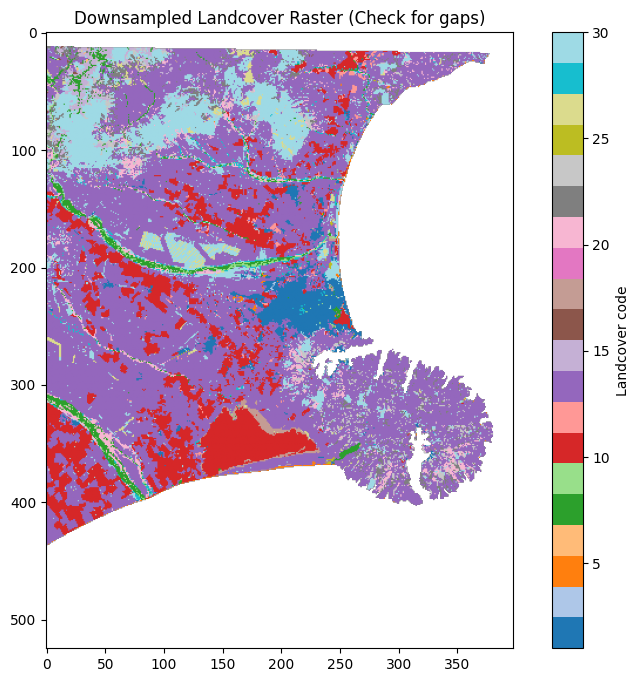

Downsampled pixels with 0: 0 / 208950 (0.00%)


In [ ]:
# import rasterio
# import numpy as np
# import matplotlib.pyplot as plt
# from rasterio.enums import Resampling

# lc_path = "/content/drive/My Drive/Colab Notebooks/landcover_raster.tif"
# step = 20  # downsampling factor

# with rasterio.open(lc_path) as src:
#     # Read downsampled raster
#     data = src.read(
#         1,
#         out_shape=(src.height // step, src.width // step),
#         resampling=Resampling.nearest
#     )
#     nodata = src.nodata
#     masked_data = np.ma.masked_equal(data, nodata)

# plt.figure(figsize=(10,8))
# plt.imshow(masked_data, cmap='tab20', origin='upper')
# plt.colorbar(label="Landcover code")
# plt.title("Downsampled Landcover Raster (Check for gaps)")
# plt.show()

# # Count zeros in downsampled array
# n_zeros = np.sum(masked_data == 0)
# n_total = masked_data.size
# print(f"Downsampled pixels with 0: {n_zeros} / {n_total} ({100*n_zeros/n_total:.2f}%)")

Downsampled DEM stats (min, max, mean): -6.0 1907.0 153.2644664154792
Calculated extent (lon_min, lon_max, lat_min, lat_max): 171.94963032469803 173.1553298939642 -44.00025202052815 -42.98915595729828


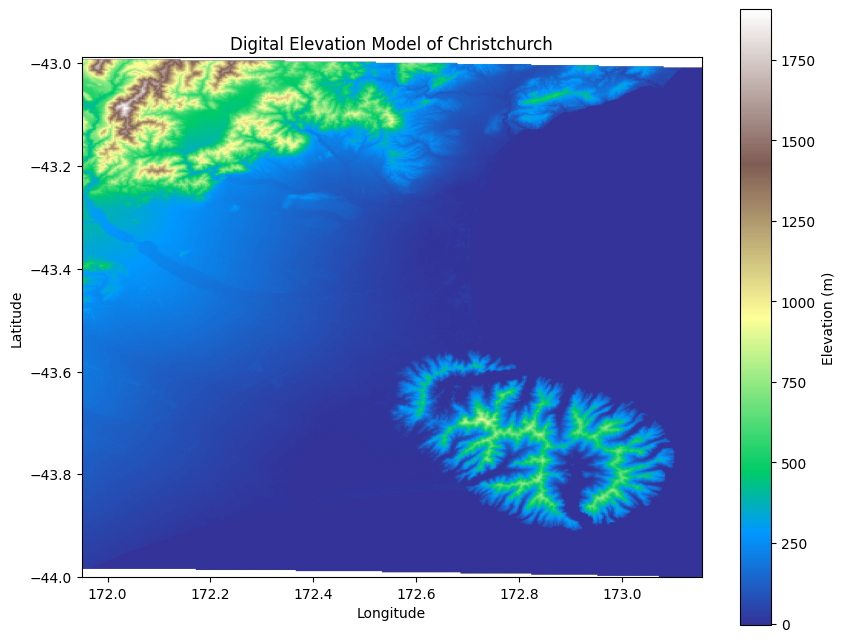

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer

dem_path = "/content/drive/My Drive/Colab Notebooks/DEM_clipped.tif" # Corrected path
downsample_factor = 10  # adjust if DEM is very large

with rasterio.open(dem_path) as src:
    # Read full DEM
    dem = src.read(1)
    dem = np.where(dem == src.nodata, np.nan, dem)

    # Downsample to save memory
    dem_ds = dem[::downsample_factor, ::downsample_factor]

    # Original transform
    transform = src.transform

    # Compute coordinates of pixels in native CRS
    height, width = dem_ds.shape
    x_coords = np.arange(width) * transform.a * downsample_factor + transform.c
    y_coords = np.arange(height) * transform.e * downsample_factor + transform.f

    # Transform to lat/lon
    transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
    lon_min, lat_min = transformer.transform(x_coords[0], y_coords[-1])
    lon_max, lat_max = transformer.transform(x_coords[-1], y_coords[0])

# Add checks for data and extent before plotting
print("Downsampled DEM stats (min, max, mean):", np.nanmin(dem_ds), np.nanmax(dem_ds), np.nanmean(dem_ds))
print("Calculated extent (lon_min, lon_max, lat_min, lat_max):", lon_min, lon_max, lat_min, lat_max)


# Mask invalid values
dem_masked = np.ma.masked_invalid(dem_ds)

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(
    dem_masked,
    cmap='terrain',
    extent=[lon_min, lon_max, lat_min, lat_max],
    origin='upper',
    aspect='equal'
)
plt.colorbar(label='Elevation (m)')
plt.title('Digital Elevation Model of Christchurch')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# Low-RAM stratified sampling + RF training + blockwise prediction
# - Uses WarpedVRT to avoid full reprojects in memory
# - Samples stratified by landcover with per-class caps
# - Keeps landcover as integer categorical (no one-hot) to save memory

import joblib
import numpy as np
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.warp import Resampling
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from math import ceil
import os # Import os

# ----------------------------
# PARAMETERS (update paths if needed)
# ----------------------------
ref_path = "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif"  # reference grid (CRS/transform/resolution)
predictor_paths = [
    "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif",                     # 0 - HH
    "/content/drive/My Drive/Colab Notebooks/HV_mosaic_filtered.tif",                     # 1 - HV
    "/content/drive/My Drive/Colab Notebooks/DEM_clipped.tif",   # 2 - DEM
    "/content/drive/My Drive/Colab Notebooks/DEM_slope.tif",     # 3 - Slope
    "/content/drive/My Drive/Colab Notebooks/DEM_aspect.tif",    # 4 - Aspect
    "/content/drive/My Drive/Colab Notebooks/modis_ndvi_clipped.tif", # 5 - NDVI
    "/content/drive/My Drive/Colab Notebooks/landcover_raster.tif"     # 6 - Landcover
]
target_path = "cci_soilm_aligned.tif"

# sampling
max_per_class = 1000          # cap per landcover class
total_random_extra = 1000     # reservoir size for extra random points
desired_total = None          # Define desired_total here
rng = np.random.default_rng(42)

# RF params
rf_params = dict(n_estimators=200, n_jobs=-1, random_state=42)

# block scanning size for building samples (tune for speed/memory)
scan_block = 512

# block size for prediction (tune)
pred_block = 128

# ----------------------------
# OPEN REFERENCE (for shape/transform/crs)
# ----------------------------
# Check if the reference file exists
if not os.path.exists(ref_path):
    print(f"Error: Reference file not found at {ref_path}")
else:
    with rasterio.open(ref_path) as ref:
        ref_meta = ref.meta.copy()
        height, width = ref.height, ref.width
        ref_transform = ref.transform
        ref_crs = ref.crs

    print("Reference:", width, "x", height, " CRS:", ref_crs)

    # ----------------------------
    # OPEN VRTS (virtual reproject) FOR TARGET & LANDCOVER FIRST
    # We'll create a WarpedVRT for:
    #  - landcover raster (nearest resampling)
    #  - target raster (bilinear)
    # Also create VRTs for predictors later for sampling/prediction.
    # ----------------------------
    def make_vrt(path, resampling=Resampling.bilinear):
        # Check if the source file for VRT exists
        if not os.path.exists(path):
            print(f"Error: Source file for VRT not found at {path}")
            return None, None
        src = rasterio.open(path)
        vrt = WarpedVRT(
            src,
            crs=ref_crs,
            transform=ref_transform,
            width=width,
            height=height,
            resampling=resampling
        )
        return src, vrt  # return both original src (so it's kept open) and vrt

    # open landcover (nearest)
    lc_src, lc_vrt = make_vrt(predictor_paths[6], resampling=Resampling.nearest)
    # open target (soil moisture) (bilinear)
    t_src, t_vrt = make_vrt(target_path, resampling=Resampling.bilinear)

    # Also open VRTs for the other predictors (we'll keep list)
    predictor_srcs = []
    predictor_vrts = []
    for idx, p in enumerate(predictor_paths):
        if idx == 6:
            # Landcover: already opened, ensure nearest resampling
            predictor_srcs.append(lc_src)
            predictor_vrts.append(lc_vrt)
        else:
            # All other predictors: use bilinear
            src, vrt = make_vrt(p, resampling=Resampling.bilinear)
            predictor_srcs.append(src)
            predictor_vrts.append(vrt)

    # Note: predictor_vrts[i] corresponds to predictor_paths[i] projected onto ref grid

    # ----------------------------
    # 1) SCAN AOI BLOCKWISE to build stratified sample indices
    # Strategy:
    #  - For each block in reference grid, read lc_block and target_block from their VRTs
    #  - Find valid pixels in that block
    #  - For each landcover class in the block, sample up to remaining slots (cap per class)
    #  - Maintain a reservoir sample for extra random points (total_random_extra)
    # ----------------------------
    lc_band_idx = 6
    class_indices = defaultdict(list)   # stores sampled (row,col) per class (bounded by max_per_class)
    extra_reservoir = []                # reservoir for extra points (holds (row,col) tuples)
    num_seen_for_reservoir = 0          # count of eligible coords seen (for reservoir algorithm)

    rows_total = 0
    for i in range(0, height, scan_block):
        i_max = min(i + scan_block, height)
        for j in range(0, width, scan_block):
            j_max = min(j + scan_block, width)
            window = ((i, i_max), (j, j_max))

            # read landcover and target for this block
            lc_block = lc_vrt.read(1, window=window)
            t_block = t_vrt.read(1, window=window)

            # valid: target not nan and lc != 0 and lc not nodata (we assume 0 nodata)
            block_valid = (~np.isnan(t_block)) & (lc_block != 0)

            if not block_valid.any():
                continue

            # coordinates within block where valid
            local_rows, local_cols = np.where(block_valid)
            # map to global coordinates
            global_rows = local_rows + i
            global_cols = local_cols + j

            # group indices by class within the block to allow filling per-class caps
            # For memory / speed, work blockwise
            unique_classes = np.unique(lc_block[block_valid])
            for cl in unique_classes:
                if cl == 0:
                    continue
                # mask for this class inside block
                class_mask = (lc_block == cl) & block_valid
                lr, lc = np.where(class_mask)
                if lr.size == 0:
                    continue
                # global coords for this class in block
                gr = lr + i
                gc = lc + j
                coords = list(zip(gr.tolist(), gc.tolist()))

                # how many more do we need for this class?
                need = max_per_class - len(class_indices[cl])
                if need <= 0:
                    # class already full; we still feed candidates to the reservoir for extras
                    for coord in coords:
                        # reservoir sampling (only for coords not already selected)
                        num_seen_for_reservoir += 1
                        if len(extra_reservoir) < total_random_extra:
                            extra_reservoir.append(coord)
                        else:
                            k = rng.integers(0, num_seen_for_reservoir)
                            if k < total_random_extra:
                                extra_reservoir[k] = coord
                    continue

                # pick up to 'need' from coords (random pick)
                if len(coords) <= need:
                    picked = coords
                else:
                    idxs = rng.choice(len(coords), size=need, replace=False)
                    picked = [coords[int(ii)] for ii in idxs]

                # add to class_indices
                class_indices[cl].extend(picked)

                # any remaining coords from this class (not picked) -> feed reservoir
                picked_set = set(picked)
                for coord in coords:
                    if coord in picked_set:
                        continue
                    num_seen_for_reservoir += 1
                    if len(extra_reservoir) < total_random_extra:
                        extra_reservoir.append(coord)
                    else:
                        k = rng.integers(0, num_seen_for_reservoir)
                        if k < total_random_extra:
                                extra_reservoir[k] = coord

            rows_total += len(global_rows)

    # after scanning
    print("Per-class counts collected:")
    for cl, coords in class_indices.items():
        print(" class", cl, ":", len(coords))
    print("Reservoir extras collected:", len(extra_reservoir))

    # Combine per-class samples and extras (deduplicate)
    sample_idx = []
    seen = set()
    for cl, coords in class_indices.items():
        for coord in coords:
            if coord not in seen:
                sample_idx.append(coord)
                seen.add(coord)

    # add extras until desired total or reservoir exhausted
    for coord in extra_reservoir:
        if coord not in seen:
            sample_idx.append(coord)
            seen.add(coord)
        if desired_total is not None and len(sample_idx) >= desired_total:
            break

    print("Total training samples after combining:", len(sample_idx))

    # Optional: if desired_total set, downsample sample_idx to desired_total
    if desired_total is not None and len(sample_idx) > desired_total:
        sample_idx = list(rng.choice(sample_idx, size=desired_total, replace=False))
        print("Downsampled to desired_total:", desired_total)

    # ----------------------------
    # 2) EXTRACT SAMPLE FEATURES (ON-DEMAND) USING predictor_vrts
    # We'll convert sample (row,col) -> (x,y) centers in ref CRS,
    # then use each predictor_vrt.sample(coords) to get values.
    # ----------------------------
    # convert (row,col) -> (x,y) world coordinates (center of pixel)
    def rc_to_xy(transform, row, col):
        x, y = transform * (col + 0.5, row + 0.5)
        return (x, y)

    coords_xy = [rc_to_xy(ref_transform, r, c) for (r, c) in sample_idx]
    n_samples = len(coords_xy)
    print("Sampling predictors for n_samples =", n_samples)

    # Create array for X with dtype float32 but last col is landcover integer cast to float
    n_features = len(predictor_vrts)  # number of predictor rasters (including landcover)
    X = np.empty((n_samples, n_features), dtype=np.float32)
    y = np.empty((n_samples,), dtype=np.float32)

    # Sample target using t_vrt (we already have t_vrt)
    # t_vrt.sample expects coords as (x,y) in vrt's crs (we used ref_crs), so coords_xy is fine
    for idx, val in enumerate(t_vrt.sample(coords_xy)):
        # val is an array-like of band values; target VRT has single band
        y[idx] = float(val[0]) if val is not None else np.nan

    # Sample predictors
    for f_idx, vrt in enumerate(predictor_vrts):
        # sample returns generator of arrays, one per coordinate
        vals = list(vrt.sample(coords_xy))
        # Each element is array-like of bands (we expect single band), so grab [0]
        colvals = np.array([v[0] if v is not None else np.nan for v in vals], dtype=np.float32)
        # If landcover index (categorical), keep as-is but store as float32
        X[:, f_idx] = colvals

    # Mask out any samples with nan predictors or nan target
    valid_rows = (~np.isnan(X).any(axis=1)) & (~np.isnan(y))
    print("Valid training samples after removing NaNs:", valid_rows.sum())

    X = X[valid_rows]
    y = y[valid_rows]
    print("Final training matrix:", X.shape, "y:", y.shape)

    # ----------------------------
    # 3) TRAIN RANDOM FOREST (landcover kept as integer float)
    # ----------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(**rf_params)
    print("Training RF on", X_train.shape[0], "samples...")
    rf.fit(X_train, y_train)
    print("RF training complete.")

    # quick validation
    y_pred = rf.predict(X_test)
    from sklearn.metrics import mean_squared_error, r2_score
    print("Holdout RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("Holdout R2:", r2_score(y_test, y_pred))

    # save model
    joblib.dump(rf, "/content/drive/My Drive/Colab Notebooks/rf_sm_model.joblib")
    print("Saved RF model.")

    # free large sample arrays (optional)
    # del X, X_train, X_test, y_train, y_test

    # ----------------------------
    # 4) BLOCKWISE PREDICTION (use predictor_vrts to read aligned windows)
    # ----------------------------
    out_pred_path = "/content/drive/My Drive/Colab Notebooks/SM_RF_predicted.tif"

    # define nodata value for output
    nodata_val = -9999.0

    # update metadata
    out_meta = ref_meta.copy()
    out_meta.update(dtype=rasterio.float32, count=1, nodata=nodata_val)

    # create output file
    with rasterio.open(out_pred_path, "w", **out_meta) as dst_out:
        for i in range(0, height, pred_block):
            i_max = min(i + pred_block, height)
            for j in range(0, width, pred_block):
                j_max = min(j + pred_block, width)
                window = ((i, i_max), (j, j_max))

                # Read predictors for this block from each VRT
                block_stack = []
                for f_idx, vrt in enumerate(predictor_vrts):
                    arr = vrt.read(1, window=window).astype(np.float32)
                    block_stack.append(arr)

                # stack to (h_blk, w_blk, n_features)
                block_stack = np.stack(block_stack, axis=-1)
                h_blk, w_blk, nf = block_stack.shape

                # flatten for prediction
                flat = block_stack.reshape(-1, nf)

                # mask invalid pixels: any NaNs or landcover==0
                flat[flat == -9999] = np.nan
                valid_flat = (~np.isnan(flat)).all(axis=1) & (flat[:, lc_band_idx] != 0)

                print(f"Processing block ({i}:{i_max}, {j}:{j_max}), valid pixels:", valid_flat.sum())

                # initialize prediction array with nodata
                preds = np.full(flat.shape[0], nodata_val, dtype=np.float32)

                # predict only on valid pixels
                if valid_flat.any():
                    X_blk = flat[valid_flat, :].astype(np.float32)
                    preds[valid_flat] = rf.predict(X_blk).astype(np.float32)

                # reshape and write to output
                predicted_block = preds.reshape(h_blk, w_blk)
                print(f"Block ({i}:{i_max}, {j}:{j_max}) prediction min/max:", np.nanmin(predicted_block), np.nanmax(predicted_block))
                print(f"Any NaNs in block?", np.isnan(predicted_block).any())
                dst_out.write(predicted_block, 1, window=window)

    print("Prediction complete. Output:", out_pred_path)

Streaming output truncated to the last 5000 lines.
Any NaNs in block? False
Processing block (7168:7296, 4480:4608), valid pixels: 14905
Block (7168:7296, 4480:4608) prediction min/max: -9999.0 -2449.544
Any NaNs in block? False
Processing block (7168:7296, 4608:4736), valid pixels: 15433
Block (7168:7296, 4608:4736) prediction min/max: -9999.0 -2949.5083
Any NaNs in block? False
Processing block (7168:7296, 4736:4864), valid pixels: 15954
Block (7168:7296, 4736:4864) prediction min/max: -9999.0 -399.682
Any NaNs in block? False
Processing block (7168:7296, 4864:4992), valid pixels: 15260
Block (7168:7296, 4864:4992) prediction min/max: -9999.0 -349.6835
Any NaNs in block? False
Processing block (7168:7296, 4992:5120), valid pixels: 7354
Block (7168:7296, 4992:5120) prediction min/max: -9999.0 -4399.3955
Any NaNs in block? False
Processing block (7168:7296, 5120:5248), valid pixels: 13566
Block (7168:7296, 5120:5248) prediction min/max: -9999.0 0.28230026
Any NaNs in block? False
Proce

In [ ]:
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn.metrics import make_scorer, r2_score
# import numpy as np

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# r2_scores = cross_val_score(rf, X, y, cv=kf, scoring=make_scorer(r2_score))
# rmse_scores = np.sqrt(-cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_squared_error'))

# print(f"Mean R²:   {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
# print(f"Mean RMSE: {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f} m³/m³")

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# --- Parameters ---
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Storage for metrics ---
r2_scores = []
rmse_scores = []

# --- Loop through folds manually to save memory ---
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train RF (reduce n_estimators for speed if needed)
    rf_fold = RandomForestRegressor(
        n_estimators=100,       # can reduce to 50 for testing
        max_depth=None,
        max_features='sqrt',
        n_jobs=-1,              # parallelize across all cores
        random_state=42
    )
    rf_fold.fit(X_train, y_train)

    # Predict and calculate metrics
    y_pred = rf_fold.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# --- Print mean ± std ---
print(f"Mean R²:   {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f} m³/m³")

Mean R²:   0.973 ± 0.002
Mean RMSE: 693.735 ± 27.219 m³/m³


In [ ]:
import rasterio

with rasterio.open("cci_soilm_aligned.tif") as src:
    print(src.meta)
    print(src.tags())

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 7975, 'height': 10511, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 59S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32759"]]'), 'transform': Affine(12.5, 0.0, 576137.25,
       0.0, -12.5, 5238240.25)}
{'ancillary_variables': 'sm_uncertainty flag t0', 'dtype': 'float32', 'long_name': 'Volumetric Soil Moisture', 'units': 'm3 m-3', 'valid_range': '[0. 1.]', 'AREA_OR_POINT': 'Area'}


In [ ]:
#Check aligned soil moisture raster
import rasterio
import numpy as np

with rasterio.open("cci_soilm_aligned.tif") as src:
    sm_arr = src.read(1)
    print("min/max soil moisture:", np.nanmin(sm_arr), np.nanmax(sm_arr))
    print("number of NaNs:", np.isnan(sm_arr).sum())

min/max soil moisture: -9999.0 0.30013946
number of NaNs: 0


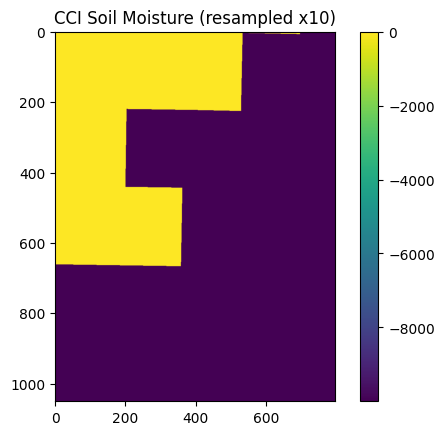

In [ ]:
import rasterio
from rasterio.enums import Resampling

scale = 10  # 10x smaller
with rasterio.open("cci_soilm_aligned.tif") as src:
    data = src.read(
        out_shape=(
            src.count,
            int(src.height / scale),
            int(src.width / scale)
        ),
        resampling=Resampling.average
    )[0]

plt.imshow(data, cmap='viridis')
plt.colorbar()
plt.title('CCI Soil Moisture (resampled x10)')
plt.show()

In [ ]:
print("Data type:", data.dtype)
print("Min:", np.nanmin(data))
print("Max:", np.nanmax(data))
print("Unique values:", np.unique(data)[:10])

Data type: float32
Min: 0.0
Max: 0.0
Unique values: [0.]


In [ ]:
import rasterio
import numpy as np

with rasterio.open("cci_soilm_aligned.tif") as src:
    arr = src.read(1, masked=True)
    print("Shape:", arr.shape)
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Data type:", arr.dtype)
    print("Min:", np.nanmin(arr))
    print("Max:", np.nanmax(arr))
    print("Unique:", np.unique(arr.compressed())[:10])
    print("NoData value:", src.nodata)

Shape: (10511, 7975)
CRS: EPSG:32759
Transform: | 12.50, 0.00, 576137.25|
| 0.00,-12.50, 5238240.25|
| 0.00, 0.00, 1.00|
Data type: float32
Min: --
Max: --
Unique: []
NoData value: 0.0


In [ ]:
print(type(aligned))
print(np.shape(aligned))

<class 'numpy.ndarray'>
(10511, 7975)


In [ ]:
plt.imshow(aligned, cmap='viridis')
plt.colorbar()
plt.title('CCI Soil Moisture clipped')
plt.show()

In [ ]:
print(y_train.describe())
print(np.unique(y_train))

NameError: name 'y_train' is not defined

In [ ]:
print("Training target min/max:", y.min(), y.max())
print("Training target mean:", y.mean())

Training target min/max: 0.0 0.0
Training target mean: 0.0


In [ ]:
import rasterio
with rasterio.open("cci_soilm_aligned.tif") as src:
    data = src.read(1)
    print("Soil moisture raster stats:", np.nanmin(data), np.nanmax(data))

Soil moisture raster stats: -9999.0 0.30013946


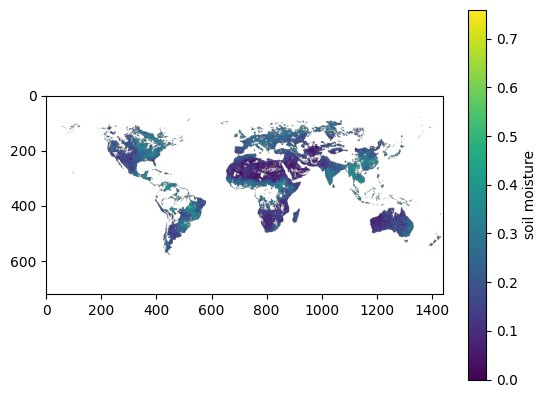

In [ ]:
plt.imshow(soil_moisture, origin='upper')
plt.colorbar(label='soil moisture')
plt.show()

In [ ]:
hh_mosaic_path = "/content/drive/My Drive/Colab Notebooks/HH_mosaic_filtered.tif"
hv_mosaic_path = "/content/drive/My Drive/Colab Notebooks/HV_mosaic_filtered.tif"
ref_path = hh_mosaic_path  # for alignment, sampling, etc.

In [ ]:
import rasterio
import numpy as np # Ensure numpy is imported for np.nanmin, np.nanmax, np.nanmean

# Path to the processed CCI soil moisture GeoTIFF
cci_soilm_path = "cci_soilm_aligned.tif"

try:
    with rasterio.open(cci_soilm_path) as src:
        data = src.read(1)

        # Print min/max/mean ignoring potential nodata values if they exist
        # Check if nodata value is defined and use it to mask
        if src.nodata is not None:
            valid_data = data[data != src.nodata]
        else:
            # If no nodata value, consider NaNs as invalid
            valid_data = data[~np.isnan(data)]

        if valid_data.size > 0:
            print("Min/max/mean of CCI soil moisture raster:", np.nanmin(valid_data), np.nanmax(valid_data), np.nanmean(valid_data))
        else:
            print("No valid data found in the CCI soil moisture raster.")

except rasterio.errors.RasterioIOError as e:
    print(f"Error opening or reading the CCI soil moisture raster at {cci_soilm_path}: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Error opening or reading the CCI soil moisture raster at cci_soilm.tif: cci_soilm.tif: No such file or directory


In [ ]:
import rasterio
import numpy as np

with rasterio.open("/content/drive/My Drive/Colab Notebooks/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20101027000000-fv09.1.nc") as src:
    data = src.read(1)
    print("Original raster stats:", np.nanmin(data), np.nanmax(data), np.nanmean(data))

No valid data found in the CCI soil moisture raster.


In [ ]:
import xarray as xr

nc_path = "/content/drive/My Drive/Colab Notebooks/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20101027000000-fv09.1.nc"
print(ds)
sm = ds['sm']  # or check variable names in ds
print("Min/max/mean:", float(sm.min()), float(sm.max()), float(sm.mean()))

<xarray.Dataset> Size: 29MB
Dimensions:         (time: 1, lat: 720, lon: 1440)
Coordinates:
  * time            (time) datetime64[ns] 8B 2010-10-27
  * lat             (lat) float32 3kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    sm              (time, lat, lon) float32 4MB ...
    sm_uncertainty  (time, lat, lon) float32 4MB ...
    flag            (time, lat, lon) float32 4MB ...
    freqbandID      (time, lat, lon) int16 2MB ...
    dnflag          (time, lat, lon) int8 1MB ...
    mode            (time, lat, lon) int8 1MB ...
    sensor          (time, lat, lon) int32 4MB ...
    t0              (time, lat, lon) datetime64[ns] 8MB ...
Attributes: (12/44)
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    institution:                  TU Wien (AUT); VanderSat B.V. (NL); Planet ...
    contact:                      cci_sm_contact@eodc.eu
    source:   

In [ ]:
import rasterio
import numpy as np

with rasterio.open("content/drive/My Drive/Colab Notebooks/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20101027000000-fv09.1.nc") as src:
    data = src.read(1)
    print("Original raster stats:", np.nanmin(data), np.nanmax(data), np.nanmean(data))

RasterioIOError: content/drive/My Drive/Colab Notebooks/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20101027000000-fv09.1.nc: No such file or directory

In [ ]:
print("Predictor min/max per band in this block:")
for band in range(X_blk.shape[1]):
    print(f"Band {band}: min={X_blk[:, band].min()}, max={X_blk[:, band].max()}")

Predictor min/max per band in this block:
Band 0: min=-60.000003814697266, max=-60.000003814697266
Band 1: min=-60.000003814697266, max=-60.000003814697266
Band 2: min=-32768.0, max=22.0
Band 3: min=-9999.0, max=9.317285537719727
Band 4: min=-9999.0, max=344.33087158203125
Band 5: min=-0.0055327387526631355, max=0.34505805373191833
Band 6: min=5.0, max=13.0


In [ ]:
!pip install rasterstats geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 68.2 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
from rasterio.warp import reproject, Resampling
from rasterio.features import geometry_mask
from shapely.geometry import box
import geopandas as gpd

predicted_hr_path = "/content/drive/My Drive/Colab Notebooks/SM_RF_predicted.tif"
coarse_sm_path = "cci_soilm_aligned.tif"
output_path = "/content/drive/My Drive/Colab Notebooks/sm_anchored_meanmatch_fixed.tif"

min_sm, max_sm = 0.0, 1.0  # realistic soil moisture range

# ---------------------------
# Load rasters
# ---------------------------
with rasterio.open(predicted_hr_path) as src_pred, rasterio.open(coarse_sm_path) as src_coarse:
    pred_hr = src_pred.read(1).astype(np.float32)
    pred_hr = np.where(pred_hr == src_pred.nodata, np.nan, pred_hr)
    pred_hr = np.clip(pred_hr, min_sm, max_sm)

    # Resample coarse raster to HR grid (bilinear)
    coarse_resampled = np.empty_like(pred_hr, dtype=np.float32)
    reproject(
        source=rasterio.band(src_coarse, 1),
        destination=coarse_resampled,
        src_transform=src_coarse.transform,
        src_crs=src_coarse.crs,
        dst_transform=src_pred.transform,
        dst_crs=src_pred.crs,
        resampling=Resampling.bilinear
    )
    coarse_resampled = np.where(coarse_resampled == src_coarse.nodata, np.nan, coarse_resampled)

    # ---------------------------
    # Mean match per coarse pixel
    # ---------------------------
    # Generate coarse pixel geometries
    coarse_h, coarse_w = src_coarse.height, src_coarse.width
    coarse_transform = src_coarse.transform
    coords_list = []
    values_list = []
    for row in range(coarse_h):
        for col in range(coarse_w):
            val = coarse_resampled[row, col]
            if np.isnan(val):
                continue
            x_min, y_max = coarse_transform * (col, row)
            x_max = x_min + coarse_transform.a
            y_min = y_max + coarse_transform.e  # note: e < 0
            coords_list.append(box(x_min, y_min, x_max, y_max))
            values_list.append(val)

    gdf = gpd.GeoDataFrame({'coarse_val': values_list, 'geometry': coords_list}, crs=src_coarse.crs)

    # Rasterize mean-matched HR
    anchored = np.full_like(pred_hr, np.nan, dtype=np.float32)

    for geom, coarse_val in zip(gdf.geometry, gdf.coarse_val):
        mask = geometry_mask([geom], transform=src_pred.transform,
                             invert=True, out_shape=pred_hr.shape)
        hr_pixels = pred_hr[mask]
        if hr_pixels.size > 0:
            hr_mean = np.nanmean(hr_pixels)
            anchored[mask] = hr_pixels + (coarse_val - hr_mean)

    # Clip final values
    anchored = np.clip(anchored, min_sm, max_sm)
    anchored[np.isnan(anchored)] = src_pred.nodata

    # ---------------------------
    # Save output
    # ---------------------------
    profile = src_pred.profile
    profile.update(dtype='float32', nodata=-9999.0)

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(anchored.astype(np.float32), 1)

print("✅ Anchored soil moisture saved:", output_path)


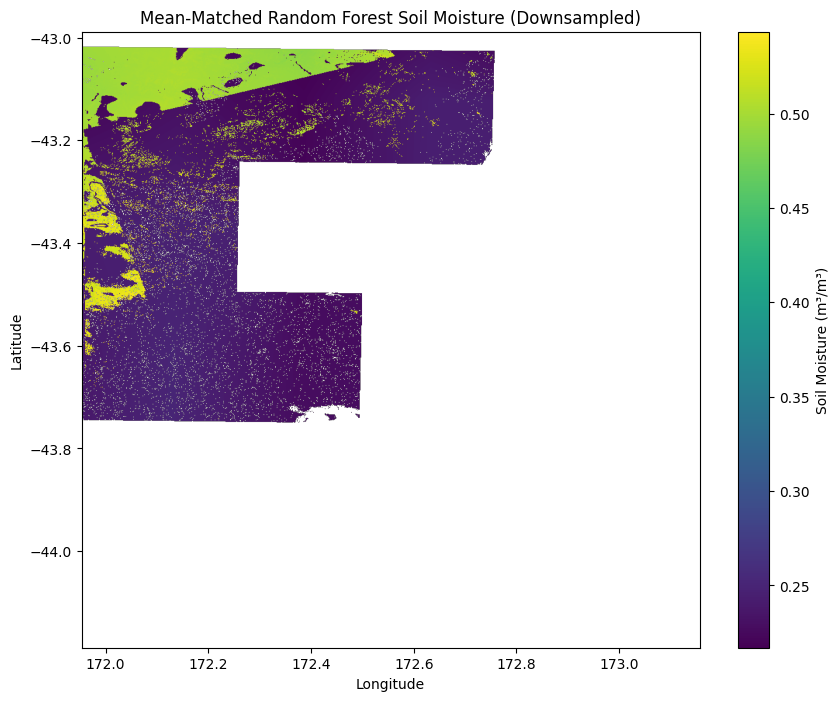

In [ ]:

from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from pyproj import Transformer

# Use the anchored output (mean-matched)
anchored_path = "/content/drive/My Drive/Colab Notebooks/sm_anchored_meanmatch_fixed.tif"
step = 10  # downsampling factor for plotting

with rasterio.open(anchored_path) as src:
    # Read full raster
    full_data = src.read(1)

    # Mask nodata
    if src.nodata is not None:
        full_data = np.where(full_data == src.nodata, np.nan, full_data)

    # Downsample for plotting
    data_down = full_data[::step, ::step]

    # Compute coordinates for downsampled raster
    transform = src.transform
    height, width = data_down.shape
    x_coords = np.arange(0, width) * step * transform.a + transform.c + 0.5 * transform.a * step
    y_coords = np.arange(0, height) * step * transform.e + transform.f + 0.5 * transform.e * step

    # Convert to lat/lon
    transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
    lon_min, lat_min = transformer.transform(x_coords[0], y_coords[-1])
    lon_max, lat_max = transformer.transform(x_coords[-1], y_coords[0])

# Mask invalid (NaNs) for plotting
masked_data = np.ma.masked_invalid(data_down)

# Plot
plt.figure(figsize=(10, 8))
im = plt.imshow(
    masked_data,
    cmap='viridis',
    vmin=masked_data.min(),
    vmax=masked_data.max(),
    extent=[lon_min, lon_max, lat_min, lat_max],
    origin='upper',
    aspect='equal'
)
plt.colorbar(im, label="Soil Moisture (m³/m³)")
plt.title("Mean-Matched Random Forest Soil Moisture (Downsampled)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
import rasterio

coarse_sm_path = "cci_soilm_aligned.tif"

with rasterio.open(coarse_sm_path) as src:
    print("CRS:", src.crs)
    print("Data type:", src.dtypes)
    print("NoData value:", src.nodata)
    print("Shape:", src.width, src.height)
    print("Transform:", src.transform)
    print("Tags:", src.tags())  # This usually contains units and other metadata


CRS: EPSG:32759
Data type: ('float32',)
NoData value: -9999.0
Shape: 7975 10511
Transform: | 12.50, 0.00, 576137.25|
| 0.00,-12.50, 5238240.25|
| 0.00, 0.00, 1.00|
Tags: {'ancillary_variables': 'sm_uncertainty flag t0', 'dtype': 'float32', 'long_name': 'Volumetric Soil Moisture', 'units': 'm3 m-3', 'valid_range': '[0. 1.]', 'AREA_OR_POINT': 'Area'}


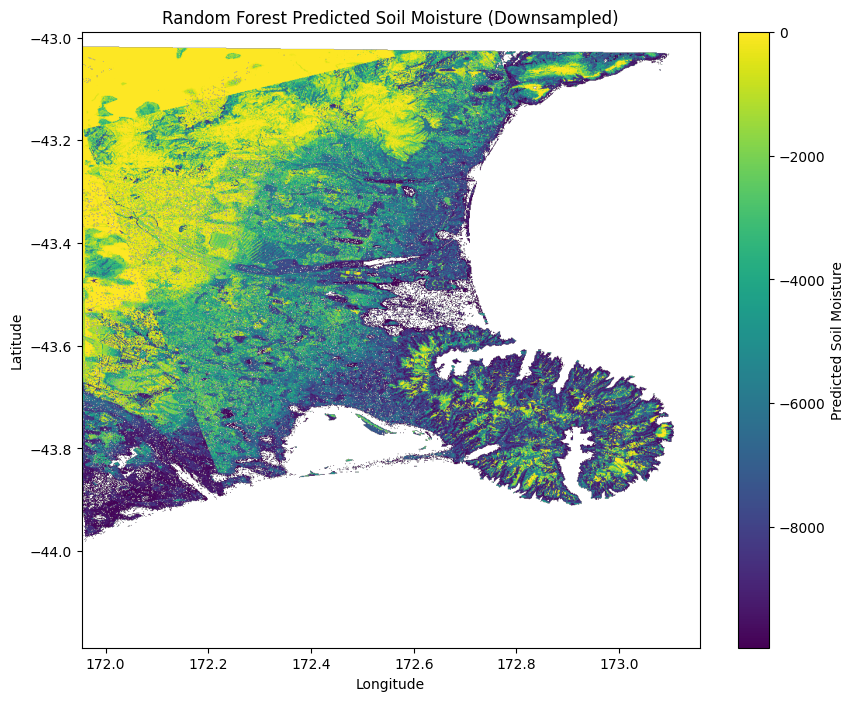

In [ ]:
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from pyproj import Transformer

pred_path = "/content/drive/My Drive/Colab Notebooks/SM_RF_predicted.tif"
step = 10  # downsampling factor

with rasterio.open(pred_path) as src:
    # Read full raster
    full_pred = src.read(1)

    # Mask nodata
    if src.nodata is not None:
        full_pred = np.where(full_pred == src.nodata, np.nan, full_pred)

    # Downsample
    pred_data = full_pred[::step, ::step]

    # Compute coordinates for the downsampled raster
    transform = src.transform
    height, width = pred_data.shape
    x_coords = np.arange(0, width) * step * transform.a + transform.c + 0.5 * transform.a * step
    y_coords = np.arange(0, height) * step * transform.e + transform.f + 0.5 * transform.e * step

    # Convert to lat/lon
    transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
    lon_min, lat_min = transformer.transform(x_coords[0], y_coords[-1])
    lon_max, lat_max = transformer.transform(x_coords[-1], y_coords[0])

# Mask invalid (NaNs) for plotting
masked_data = np.ma.masked_invalid(pred_data)

# Plot
plt.figure(figsize=(10,8))
im = plt.imshow(
    masked_data,
    cmap='viridis',
    vmin=masked_data.min(),
    vmax=masked_data.max(),
    extent=[lon_min, lon_max, lat_min, lat_max],
    origin='upper',
    aspect='equal'  # keeps proper lat/lon scaling
)
plt.colorbar(im, label="Predicted Soil Moisture")
plt.title("Random Forest Predicted Soil Moisture (Downsampled)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


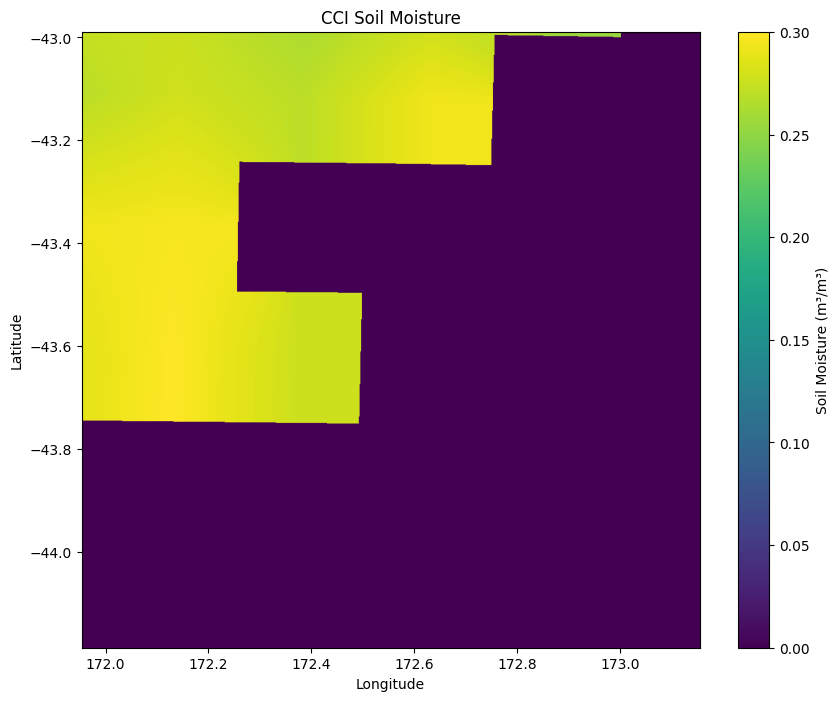

In [ ]:
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer

scale = 10  # downsample factor

with rasterio.open("cci_soilm_aligned.tif") as src:
    # Read and mask NoData
    data = src.read(1)
    data = np.where(data == src.nodata, np.nan, data)

    # Apply scaling if needed (CCI often uses 0.001 scale)
    data = data * 0.001  # adjust if your product uses a different scale

    # Clip to realistic volumetric soil moisture range
    data = np.clip(data, 0.0, 1.0)

    # Resample data
    data_resampled = src.read(
        out_shape=(
            src.count,
            int(src.height / scale),
            int(src.width / scale)
        ),
        resampling=Resampling.average
    )[0]

    # Mask NoData in resampled array
    data_resampled = np.where(np.isnan(data_resampled), np.nan, data_resampled)
    data_resampled = np.clip(data_resampled, 0.0, 1.0)

    # Compute transform for resampled raster
    transform = src.transform
    new_transform = rasterio.Affine(
        transform.a * scale, transform.b, transform.c,
        transform.d, transform.e * scale, transform.f
    )

    # Compute corner coordinates in raster CRS
    height, width = data_resampled.shape
    x_coords = np.arange(width) * new_transform.a + new_transform.c + new_transform.a / 2
    y_coords = np.arange(height) * new_transform.e + new_transform.f + new_transform.e / 2

    # Convert to lat/lon
    transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
    lon_min, lat_min = transformer.transform(x_coords[0], y_coords[-1])
    lon_max, lat_max = transformer.transform(x_coords[-1], y_coords[0])

# Mask invalid values for plotting
data_masked = np.ma.masked_invalid(data_resampled)

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(
    data_masked,
    cmap='viridis',
    extent=[lon_min, lon_max, lat_min, lat_max],
    origin='upper',
    aspect='equal'
)
plt.colorbar(label="Soil Moisture (m³/m³)")
plt.title('CCI Soil Moisture')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
